In [1]:
# Homework 05
# Vance Nygard's solutions.
## Due Tuesday, March 29th

In [126]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import shapely.geometry
import shapely.ops

from scipy import spatial
from mpl_toolkits.basemap import Basemap

from scipy import interpolate


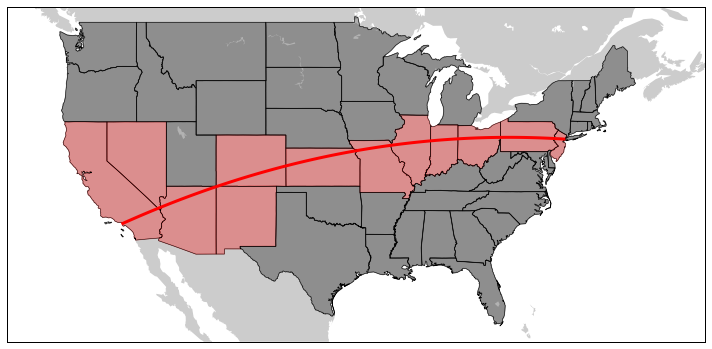

In [70]:
##Problem 1
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111) 
m = Basemap(llcrnrlon=-130.,llcrnrlat=23.5,
        urcrnrlon=-60.,urcrnrlat=50.,
        rsphere=(6378137.00,6356752.3142),
        resolution='l',projection='merc',
        lat_0=40.,lon_0=-100.,lat_ts=20.)
ax = fig.add_subplot(111)
m.fillcontinents();
m.readshapefile('states_21basic/states', 'states');


latLAX = 33.9425
lonLAX = -118.4081
latEWR = 40.6925
lonEWR = -74.1686

pathx, pathy = m.gcpoints(lonLAX, latLAX, lonEWR, latEWR, 120)
ax.plot(pathx,pathy)

states = shapely.ops.linemerge(m.states)
line = shapely.geometry.LineString(zip(pathx, pathy))
dialated = line.buffer(100)
dialated_points = shapely.geometry.MultiPoint(zip(pathx, pathy)).buffer(100)
regions = shapely.ops.linemerge(dialated_points.boundary)

# for poly in states:
#     if poly.intersects(regions):
#         color = 'purple'
#     else:
#         continue
#     coords = shapely.ops.cascaded_union(poly).coords[:]
#     x, y = zip(*coords)
#     plt.fill(x, y, color=color, alpha=0.3)
    
for poly in states:
    if poly.intersects(line):
        color = 'r'
    else:
        color = 'k'
    coords = shapely.ops.cascaded_union(poly).coords[:]
    x, y = zip(*coords)
    plt.fill(x, y, color=color, alpha=0.3)
    
x, y = zip(*line.coords[:])
plt.plot(x, y, '-r', lw = 3)
# plt.fill(*dialated_points.boundary.xy, alpha = 0.5)
# plt.fill(*dialated.boundary.xy)#, alpha=0.2)
plt.gca().set_aspect(1.0)

0.986090261784  is the fraction at least 0.001 units away from edges
0.865253615351  is the fraction at least 0.01 units away from edges
0.0924424566394  is the fraction at least 0.1 units away from edges


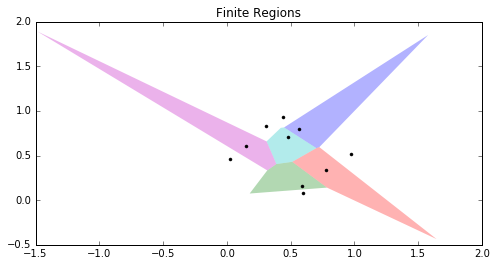

In [228]:
##Problem 2
arr = np.array([[ 0.77354201,  0.34072038],
                [ 0.43807549,  0.93001924],
                [ 0.5624092 ,  0.79438991],
                [ 0.02536295,  0.46180244],
                [ 0.59533179,  0.07522803],
                [ 0.47867418,  0.70302822],
                [ 0.30371564,  0.83135442],
                [ 0.5856915 ,  0.16340903],
                [ 0.14700491,  0.60268997],
                [ 0.97098631,  0.51692456]])

vor = spatial.Voronoi(arr)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)  
ax.set_title('Finite Regions')
plt.plot(arr[:, 0], arr[:, 1], '.k')

area = 0
area_001 = 0
area_01 = 0
area_1 = 0

for indices in vor.regions:
    if not indices: continue     # empties
    if -1 in indices: continue   # regions extending beyond diagram
    plt.fill(vor.vertices[indices, 0], vor.vertices[indices, 1], edgecolor='none', alpha=0.3)
    xy = zip(vor.vertices[indices, 0], vor.vertices[indices, 1])
    area = area + shapely.geometry.Polygon(xy).area
    area_001 += shapely.geometry.Polygon(xy).buffer(-0.001).area
    area_01 += shapely.geometry.Polygon(xy).buffer(-0.01).area
    area_1 += shapely.geometry.Polygon(xy).buffer(-0.1).area

print area_001/area , " is the fraction at least 0.001 units away from edges."
print area_01/area , " is the fraction at least 0.01 units away from edges."
print area_1/area , " is the fraction at least 0.1 units away from edges."

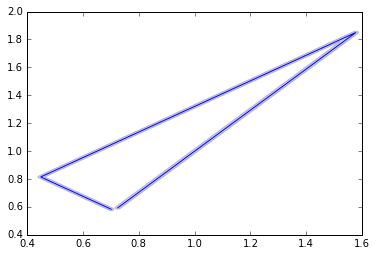

In [210]:
# IGNORE THIS CELL FOR GRADING PURPOSES #
xy = zip(vor.vertices[vor.regions[1], 0], vor.vertices[vor.regions[1], 1])
line = shapely.geometry.LineString(xy)
dialated = line.buffer(0.01)

plt.plot(*line.xy)
plt.fill(*dialated.boundary.xy, alpha=0.2)
# plt.fill(vor.vertices[vor.regions[1], 0], vor.vertices[vor.regions[1], 1])

# xy = zip(vor.regions)

# poly = shapely.geometry.Polygon(xy)
# IGNORE THIS CELL FOR GRADING PURPOSES #

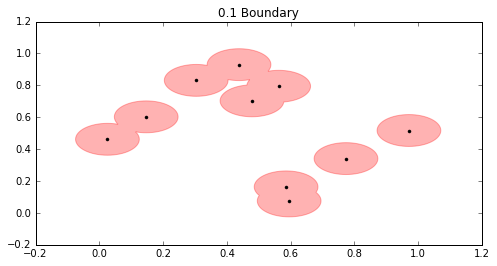

In [231]:
# IGNORE THIS CELL FOR GRADING PURPOSES #
points_1 = shapely.geometry.MultiPoint(arr).buffer(0.1)
regions_1 = shapely.ops.linemerge(points_1.boundary)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)  
ax.set_title('0.1 Boundary')
plt.plot(arr[:, 0], arr[:, 1], '.k')

for poly in regions_1:
    color = 'r'
    
    coords = shapely.ops.cascaded_union(poly).coords[:]
    x, y = zip(*coords)
    plt.fill(x, y, color=color, alpha=0.3)
# IGNORE THIS CELL FOR GRADING PURPOSES #

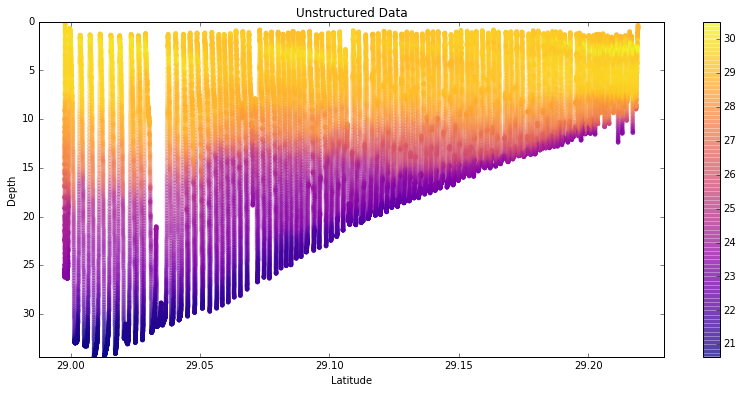

In [169]:
#Problem 3.

file  = '../python4geosciences/data/MS03_L15.txt'
data = np.loadtxt(file,comments='*')
lat = data[:,0]
dep = data[:,2]
temp = data[:,3]

fig, ax = plt.subplots(1,1,figsize=(14,6))
mappable = ax.scatter(lat, dep, c=temp, cmap = 'plasma', edgecolors = 'none', alpha=0.5)
ax.set_xlim(np.min(lat)-0.01, np.max(lat)+0.01)
ax.set_xlabel('Latitude')
ax.set_ylim(np.min(dep), np.max(dep))
ax.set_ylabel('Depth')
ax.invert_yaxis()
ax.set_title('Unstructured Data')
fig.colorbar(mappable)

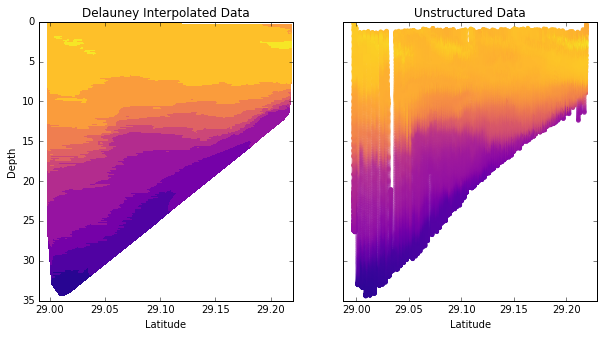

In [171]:
#Problem 3, Continued.

bounds = np.linspace(20,31, 12)

tri = spatial.Delaunay(zip(lat,dep))
interp = interpolate.LinearNDInterpolator(tri, temp)

ygrid, zgrid = np.mgrid[0:35:350j, 28.99:29.22:2300j]
tgrid = interp(zgrid, ygrid)

tgrid = np.ma.masked_where(np.isnan(tgrid), tgrid)

fig, axs = plt.subplots(1, 2,  sharey = True, figsize=(10, 5))
mappable1 = axs[0].contourf(zgrid, ygrid, tgrid, cmap='plasma',levels = bounds, vmin = 20, vmax = 31)
axs[0].invert_yaxis()
axs[0].set_xlabel('Latitude')
axs[0].set_ylabel('Depth')
axs[0].set_title('Delauney Interpolated Data')

mappable2 = axs[1].scatter(lat, dep, c=temp, cmap = 'plasma', edgecolors = 'none', alpha=0.5, vmin = 20, vmax =31)
axs[1].set_xlim(np.min(lat)-0.01, np.max(lat)+0.01)
axs[1].set_xlabel('Latitude')
axs[1].set_ylim(np.min(dep), 35)
axs[1].invert_yaxis()
axs[1].set_title('Unstructured Data')
# fig.colorbar(mappable2, orientation = 'horizontal')


In [36]:
#Problem 4
m1 = Basemap(projection='merc',llcrnrlat=-40,urcrnrlat=84,\
            llcrnrlon=-75,urcrnrlon=155,lat_ts=20,resolution='c')
m2 = Basemap(projection='robin',lon_0=50,resolution='c')
m3 = Basemap(projection='moll',lon_0=50,resolution='c')

merc_g = m1.readshapefile('../python4geosciences/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
merc_a = m1.readshapefile('../python4geosciences/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)

robin_g = m2.readshapefile('../python4geosciences/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
robin_a = m2.readshapefile('../python4geosciences/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)

moll_g = m3.readshapefile('../python4geosciences/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
moll_a = m3.readshapefile('../python4geosciences/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)

In [137]:
ax.contourf?

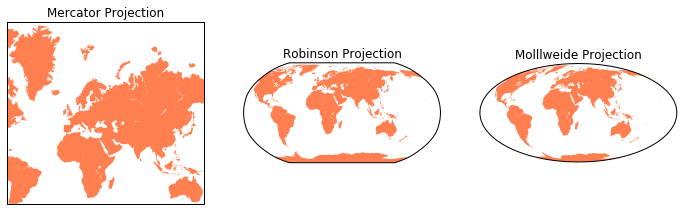

In [37]:
# Problem 4, Continued
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(131)  
m1.fillcontinents(color = 'coral')
ax.set_title('Mercator Projection')

ax2 = fig.add_subplot(132) 
m2.fillcontinents(color = 'coral')
ax2.set_title('Robinson Projection')

ax3 = fig.add_subplot(133)  
m3.fillcontinents(color = 'coral')
ax3.set_title('Mollweide Projection')

In [38]:
#Problem 4, Continued.

merc_g_size = shapely.ops.linemerge(merc_g)
merc_a_size = shapely.ops.linemerge(merc_a)

robin_g_size = shapely.ops.linemerge(robin_g)
mobin_a_size = shapely.ops.linemerge(robin_a)

moll_g_size = shapely.ops.linemerge(moll_g)
moll_a_size = shapely.ops.linemerge(moll_a)

AttributeError: 'int' object has no attribute '_ndim'

In [39]:
np.unique?